# `pandas dtypes` 

In [Section 1.1](./1_1_introduction_to_pandas.ipynb), we took our first look at the `pandas.DataFrame`.  In this section, we will take a closer look at `pandas` column types.

In [2]:
import pandas as pd
from dfply import *

## Hiding stack traceback

We hide the exception traceback for didactic reasons (code source: [see this post](https://stackoverflow.com/questions/46222753/how-do-i-suppress-tracebacks-in-jupyter)).  Don't run this cell if you want to see a full traceback.

In [3]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

## Outline

* Three more `dtypes`
    * `datetime`
    * `Int64`
    * `category`
* Setting the `dtypes` at read time.

## Integers with missing values

* Older `pandas` $\rightarrow$ no missing `int`
    * Use `float` instead
* Latest version $\rightarrow$ `Int` classes
    * Notice the capital `I`

## Example - Artist `BeginDate` and `EndDate`

In [4]:
artist = pd.read_csv('./data/Artists.csv')
artist.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN


## There are lots of `0`s in the `BeginDate` 

Do we really think the Museam of **Modern** Art has artists from 0AD?

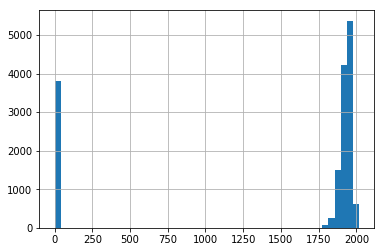

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
artist.BeginDate.hist(bins=50)

## Same problem with `EndDate`, but even more so

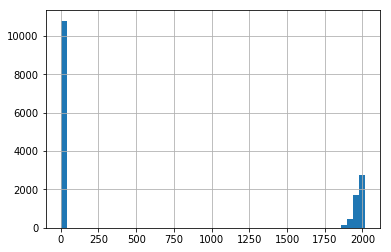

In [6]:
artist.EndDate.hist(bins=50)

## Using `apply` to remove the `0`s

In [7]:
transformed_BD = artist.BeginDate.apply(lambda val: np.nan if val == 0 else val)
transformed_BD.head()

0    1930.0
1    1936.0
2    1941.0
3    1946.0
4    1941.0
Name: BeginDate, dtype: float64

## What's up with the `float dtype`?

Good question, let's find out.

## Converting transformed `BeginDate` - attempt 1

Let's try to convert the `BeginDate` to `int`

In [8]:
transformed_BD.astype('int')

ValueError: Cannot convert non-finite values (NA or inf) to integer

## `pandas`, `int` and `np.nan` don't mix

* `pandas` `int` columns **cannot** have missing
* `pd.__version__ == 0.24.1` fixes this
    * Use `Int64` for integers with missing values
    * Note the capital `I`
* Update with `!pip install --upgrade pandas`

In [9]:
# TODO Make this future proof
assert pd.__version__.startswith('0.24'), "Please upgrade your pandas and restart jupyter"
#!pip install --upgrade pandas

## Converting `BeginDate` to `Int64`

Hmm, that returned a `float` column.  Let's try to force `Int64`

In [10]:
transformed_BD.astype('Int64').head(15) # There we go!

0     1930
1     1936
2     1941
3     1946
4     1941
5     1925
6     1941
7     1923
8     1918
9     1886
10    1936
11    1911
12    1907
13    1900
14     NaN
Name: BeginDate, dtype: Int64

## `Integers` in other frameworks

* Both `sqlalchemy.Integer` and `pyspark.Integer` handle missing values.
* `sqlalchmey`
    * Allow missing is default
    * Set `keys` in `pd.io.sql.get_schema` for non-nullable.
* `pyspark`
    * Nullable: `StructField('Age', IntegerType(), True)`
    * No Nulls: `StructField('Age', IntegerType(), False)`

## Example 2 - Uber rides

**Source:** [FiveThirtyEight Uber data](https://github.com/fivethirtyeight/uber-tlc-foil-response)

**Note:** The actual data is pretty large, which we will deal with in the next section.  For now, we will load a subset (first 1000 rows).

In [11]:
uber_april_raw = pd.read_csv("./data/uber-raw-data-apr14-small.csv")
uber_april_raw.head()

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


## <font color="red"> Exercise 1</font>

Fix the names.  Be sure to rename the `"Date/Time"` `'date'` and name the resulting data frame `uber_april_renamed`.

In [16]:
# Your code here

## <font color="red"> Exercise 2</font>

**Tasks:**

1. Inspect the `dtypes`
2. Suggest a good type for the `date` column

In [18]:
# Your code here

> *Your answer here*

## Changing to date type with  `pd.to_datetime`

In [20]:
pd.to_datetime(uber_april_rename.date.head())

0   2014-04-01 00:11:00
1   2014-04-01 00:17:00
2   2014-04-01 00:21:00
3   2014-04-01 00:28:00
4   2014-04-01 00:33:00
Name: date, dtype: datetime64[ns]

## Making a `dfply` compatible column function.

Suppose you have a function you want to use inside `mutate` (i.e. a **column function**).  To make this function compatable with `dfply.Intention`s, you should 

1. Wrap the `pandas` call inside a function.
2. Decorate with `@make_symbolic`

In [21]:
@make_symbolic
def to_datetime(series, infer_datetime_format=True):
    return pd.to_datetime(series, infer_datetime_format=infer_datetime_format)

## Converting to dates with `dfply`

Note that above function is available in `more_dfply.to_datetime` is a `dfply` compatible version of `pd.to_datetime`.

In [23]:
from more_dfply import to_datetime
uber_april = (uber_april_rename >>
                mutate(date = to_datetime(X.date)))
uber_april.dtypes

date    datetime64[ns]
lat            float64
lon            float64
base            object
dtype: object

## Why convert to `datetime`?

This series type provides many useful date methods and attributes.  For example, we get many **dateparts methods** in the `dt` attribute.

In [24]:
uber_april_weekday = (uber_april  >>
                        mutate(weekday = X.date.dt.weekday_name))
uber_april_weekday.head()

,date,lat,lon,base,weekday
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday


## <font color="red"> Exercise 3</font>

**Tasks:**

1. Use `dir` to inspect the dateparts found in `dt`
2. Add a few more datepart columns.
3. Name the resulting dataframe `uber_april_datepart`

In [36]:
# Your code here

> *Your answer here*

## `datetime`s and `timedelta`s

* A `datetime` is an instance in time.
* A `timedelta` is a length of time.
* Python and pandas have both representations.

## Timedeltas in Python

Use [datetime.timedelta](https://docs.python.org/3/library/datetime.html#datetime.timedelta)

In [25]:
import datetime as dt

dt.timedelta(days = 1, minutes = 1, seconds = 1)

datetime.timedelta(1, 61)

In [26]:
td1 = dt.timedelta(days = 1, minutes = 1, seconds = 1)
td2 = dt.timedelta(days = 23)
td1 + td2

datetime.timedelta(24, 61)

##  Combining datetimes and timedeltas

Signature: `datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)`

In [27]:
dt1 = dt.datetime(2018, 1, 3, hour=12, minute=3)
dt1

datetime.datetime(2018, 1, 3, 12, 3)

In [28]:
dt1 + td1

datetime.datetime(2018, 1, 4, 12, 4, 1)

In [30]:
dt1 - 2*td1

datetime.datetime(2018, 1, 1, 12, 0, 58)

## `pandas.TimeDelta` operations

In [45]:
s = pd.Series(pd.date_range('2012-1-1', periods=3, freq='D'))
td = pd.Series([pd.Timedelta(days=i) for i in range(3)])
df = pd.DataFrame({'A': s, 'B': td})
df

,A,B
0,2012-01-01,0 days
1,2012-01-02,1 days
2,2012-01-03,2 days


## Combining `datetime` and `timedelta`

`datetime` + `timedelta` == `datetime`

In [36]:
df = (df >>
       mutate(C = X.A + X.B))
df

,A,B,C
0,2012-01-01,0 days,2012-01-01
1,2012-01-02,1 days,2012-01-03
2,2012-01-03,2 days,2012-01-05


In [46]:
df.dtypes

A     datetime64[ns]
B    timedelta64[ns]
dtype: object

## `pd.offsets` is convenient

We can use `pd.offsets` to quickly apply time shifts.

In [43]:
s + pd.offsets.Minute(5)

0   2012-01-01 00:05:00
1   2012-01-02 00:05:00
2   2012-01-03 00:05:00
dtype: datetime64[ns]

In [44]:
s + pd.offsets.Minute(5) + pd.offsets.Milli(5)

0   2012-01-01 00:05:00.005
1   2012-01-02 00:05:00.005
2   2012-01-03 00:05:00.005
dtype: datetime64[ns]

## Specifying date columns while reading

Pass a list of date columns to `parse_dates`

In [40]:
from toolz import first
uber_april_with_datetime = pd.read_csv("./data/uber-raw-data-apr14-small.csv", 
                                       parse_dates=['Date/Time'])

uber_april_with_datetime.dtypes

Date/Time    datetime64[ns]
Lat                 float64
Lon                 float64
Base                 object
dtype: object

## Explicit date parsing

* Create a parser function
* Pass to `date_parser`
* Use if `pandas` fails to parse
* More information about format codes [here](https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior)

In [12]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
uber_april_parsered = pd.read_csv('./data/uber-raw-data-apr14-small.csv', 
                              parse_dates=['Date/Time'],
                              date_parser=dateparse)
uber_april_parsered.head()

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


## Dates in the other frameworks

* `sqlalchemy` has 
    * `Date` for just [calendar dates](https://docs.python.org/2/library/datetime.html#date-objects)
    * `DateTime` for [Dates and Times](https://docs.python.org/2/library/datetime.html#datetime-objects)
    * `Interval` for [Time intervals](https://docs.python.org/2/library/datetime.html#timedelta-objects)
* For `pyspark`
    * `DateType` for just [calendar dates](https://docs.python.org/2/library/datetime.html#date-objects)
    * `TimestampType` for [Dates and Times](https://docs.python.org/2/library/datetime.html#datetime-objects)

## Categorical dtype

* Similar to `R`s factor
* Allows for nominal or ordinal categories

In [42]:
uber_april_weekday_cat = (uber_april_weekday >>
                            mutate(weekday = X.weekday.astype('category')))
uber_april_weekday_cat.dtypes

date       datetime64[ns]
lat               float64
lon               float64
base               object
weekday          category
dtype: object

## Let's plot the weekdays with `seaborn.catplot`

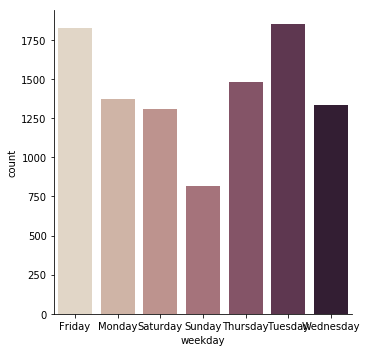

In [43]:
import seaborn as sns
sns.catplot(x="weekday", 
            kind="count", 
            palette="ch:.25", 
            data=uber_april_weekday_cat);

## Nominal by default

* Setting `'category'` makes this nominal
* Weekdays are actually ordinal
* Notice the alphabetical order in the plot.

## Making the data ordinal

1. Make a new category class with `CategoricalDtype`
2. Use `astype` with your new dtype class

#### Making an order weekday category

In [44]:
from calendar import day_name
list(day_name)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [45]:
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)
weekday_categories

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
                 ordered=True)

#### Changing to our custom type

In [46]:
uber_april_weekday_ord = (uber_april_weekday >>
                            mutate(weekday = X.weekday.astype(weekday_categories)))
uber_april_weekday_ord.dtypes

date       datetime64[ns]
lat               float64
lon               float64
base               object
weekday          category
dtype: object

## Plot the ordinal weekdays with `seaborn.catplot`

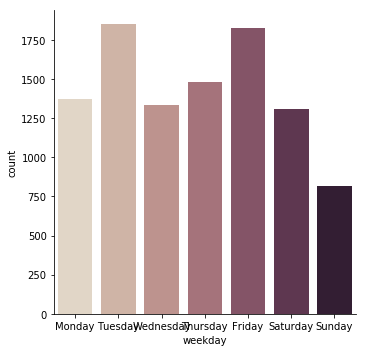

In [47]:
import seaborn as sns
sns.catplot(x="weekday", 
            kind="count", 
            palette="ch:.25", 
            data=uber_april_weekday_ord);

## <font color="red"> Exercise 4</font>

Sometimes there is an advantage to treating calendar years as ordinal data.  Perform the following steps on the `Artist` data loaded above.

**Tasks:**

1. Remove the `0` from `BeginDate` and switch the type to `Int64`.
2. Filter out the rows that are missing `BeginDate`
3. Determine the minimum and maximum values of the filtered `BeginDate`s
4. Create a new ordinal category class for this date range.
5. Use `sns.catplot` to plot the distribution of the dates.

In [36]:
# Your code here

> *Your answer here*

## Categorical types in the other frameworks.

* `sqlalchemy` has `Enum`, but it is not supported by all SQL engines
* `pyspark` does not have an `Enum`
* It is safer to use string or ints in each case.

## Up Next

1. Now you should complete [Lab 1](./lab_1_super_powers_and_SQL.ipynb) to practice creating a `sqlalchemy` database, then
2. We will look at using `DataFrame`s in `pyspark` in [Lecture 1.3](./1_3_introduction_to_pyspark_dataframes.ipynb)
3. We will take a unified look queries in [Lecture 2.1](./2_1_dataframe_verbs_select_filter_mutate.ipynb)